# **JPEG Simulation**

## Specifications

### Introduction

This notebook demonstrates the process of encoding and decoding an image using the JPEG algorithm. The steps include Discrete Cosine Transform (DCT), quantization, Huffman encoding, and run-length encoding for the encoding process, and the reverse for the decoding process.

Here's a general outline of implementation:

1. **DCT (Discrete Cosine Transform)**: The `dct` function in the `encoder` module likely transforms each 8x8 block of the image from the spatial domain to the frequency domain. This separates the high-frequency and low-frequency information in the block.

2. **Quantization**: The `quantize` function in the `encoder` module likely divides the DCT coefficients by a quantization matrix, which applies more compression to the high-frequency components. This is the lossy part of the compression.

3. **Run-Length Encoding**: The `run_length_encoding` function in the `encoder` module likely encodes the quantized coefficients using run-length encoding to reduce the size.

4. **Huffman Encoding**: The `huffman_encode` function in the `encoder` module likely encodes the run-length encoded coefficients using Huffman coding to further reduce the size.

5. **File Writing**: The encoded data is likely written to a file along with a header containing information needed to decompress the image.

For decompression, these steps are performed in reverse order:

1. **File Reading**: The compressed data and header are read from the file.

2. **Huffman Decoding**: The `huffman_decode` function in the `decoder` module likely decodes the Huffman encoded data.

3. **Run-Length Decoding**: The `run_length_decoding` function in the `decoder` module likely decodes the run-length encoded data.

4. **Dequantization**: The `dequantize` function in the `decoder` module likely multiplies the run-length decoded data by the quantization matrix to recover the DCT coefficients.

5. **IDCT (Inverse Discrete Cosine Transform)**: The `idct` function in the `decoder` module likely transforms each 8x8 block of the image from the frequency domain back to the spatial domain.

6. **Image Reconstruction**: The `reconstruct_image` function in the `decoder` module likely reconstructs the image from the 8x8 blocks.


## Import necessary modules

We are importing various modules from our encoder and decoder packages. These modules will help us in performing DCT, quantization, Huffman encoding, run-length encoding, and their inverse operations.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

In [64]:
import importlib
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import src.encoder.dct as enc_dct
import src.encoder.read_image as enc_read
import src.encoder.quantize as enc_quantize
import src.encoder.huffman_encode as enc_huff
import src.encoder.run_length_encoding as enc_rle
import src.encoder.transform_1d as enc_trans1d
import src.decoder.huffman_decode as dec_huff
import src.decoder.run_length_decoding as dec_rle
import src.decoder.transform_2d as dec_trans2d
import src.decoder.idct as dec_idct
import src.decoder.reconstruct_image as dec_recon
import src.decoder.dequantize as dec_dequantize
import src.utils.compare_images as utils_comp


In [65]:
# Reload the modules
importlib.reload(enc_dct)
importlib.reload(enc_read)
importlib.reload(enc_quantize)
importlib.reload(enc_huff)
importlib.reload(enc_rle)
importlib.reload(enc_trans1d)
importlib.reload(dec_huff)
importlib.reload(dec_rle)
importlib.reload(dec_trans2d)
importlib.reload(dec_idct)
importlib.reload(dec_recon)
importlib.reload(dec_dequantize)
importlib.reload(utils_comp)

<module 'src.utils.compare_images' from 'd:\\Repos\\JPEG-Encoder-Decoder\\src\\utils\\compare_images.py'>

In [66]:

from src.encoder.dct import Block8_DCT
from src.encoder.read_image import read_image
from src.encoder.quantize import QuantizationTable
from src.encoder.quantize import quantize
from src.encoder.huffman_encode import huffman_encode
from src.encoder.run_length_encoding import run_length_encode
from src.encoder.transform_1d import serpentine_scan
from src.decoder.huffman_decode import huffman_decode
from src.decoder.run_length_decoding import run_length_decode
from src.decoder.transform_2d import serpentine_scan_reverse
from src.decoder.idct import Block8_IDCT
from src.decoder.reconstruct_image import reconstruct_image
from src.decoder.dequantize import dequantize
from src.utils.compare_images import compare_images


## Loading the image

We are loading an image from our data set to demonstrate the encoding and decoding process. This particular image was chosen because it has a required specifications of being gray-scale image.

In [3]:
# Load image path
load_image_path = '../data/raw/cat_2k_raw.jpg'

# Extract the filename from the path
filename = os.path.basename(load_image_path)

# Remove the extension
image_name = os.path.splitext(filename)[0]

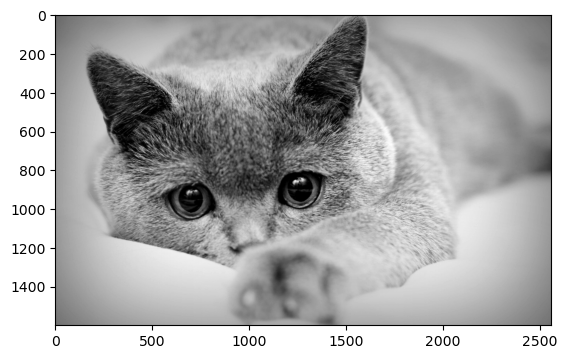

In [4]:


def load_image(file_path):
    img = Image.open(file_path).convert('L')
    return img

img = load_image(load_image_path)

# Plot the image
plt.imshow(img, cmap='gray')
plt.show()

In [5]:
import imageio

# Step 1: Load the original image
original_image = imageio.imread(load_image_path)

# Step 2: Get the number of rows and columns
rows, cols = original_image.shape[0] // 8, original_image.shape[1] // 8

C:\Users\Lord MZ\AppData\Local\Temp\ipykernel_8680\155663793.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_image = imageio.imread(load_image_path)


## Encoding

In [6]:
# Step 1: Read the image and divide it into 8x8 blocks
blocks, original_shape = read_image(load_image_path)


In [7]:
print(blocks.shape,blocks[0].shape)

(64000, 8, 8) (8, 8)


In [8]:

image_reconstruct_test = reconstruct_image(blocks, original_shape)


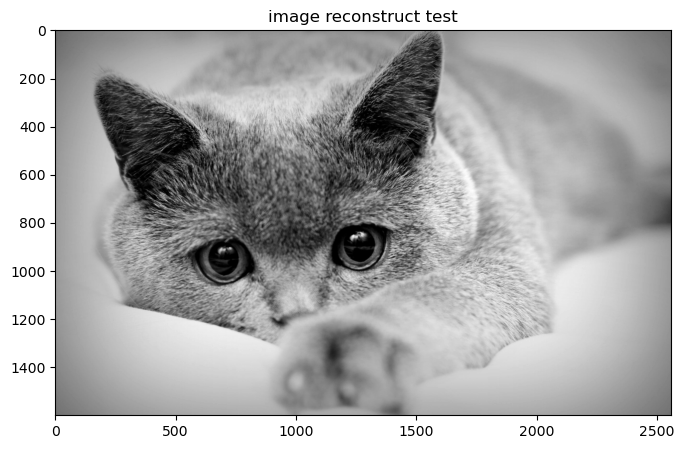

In [9]:

# Step 13: Preview the images
plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
plt.imshow(image_reconstruct_test, cmap='gray')
plt.title('image reconstruct test') 


plt.show()

### Performing DCT

We start the encoding process by performing a Discrete Cosine Transform (DCT) on the image. This transforms the image from the spatial domain to the frequency domain, separating the high-frequency and low-frequency information.

In [10]:

# Step 2: Perform DCT on each block
dct_blocks = np.array([Block8_DCT(block) for block in blocks])



In [11]:
dct_blocks.shape

(64000, 8, 8)

In [12]:
blocks[27]

array([[132, 132, 132, 132, 132, 132, 132, 132],
       [132, 132, 132, 132, 132, 132, 132, 132],
       [132, 132, 132, 132, 132, 132, 132, 132],
       [132, 132, 132, 132, 132, 132, 132, 132],
       [133, 133, 133, 133, 133, 133, 133, 133],
       [133, 133, 133, 133, 133, 133, 133, 133],
       [133, 133, 133, 133, 133, 133, 133, 133],
       [133, 133, 133, 133, 133, 133, 133, 133]], dtype=uint8)

In [13]:
dct_blocks[27]

array([[ 1.32500000e+02,  1.42108547e-14, -2.84217094e-14,
         1.42108547e-14,  7.10542736e-15,  6.39488462e-14,
        -4.97379915e-14, -1.06581410e-14],
       [-6.40728862e-01,  1.55431223e-15, -1.77635684e-15,
        -3.10862447e-15, -8.88178420e-16,  3.99680289e-15,
        -3.55271368e-15,  4.44089210e-16],
       [-1.77635684e-14, -2.22044605e-16, -1.77635684e-15,
         2.22044605e-16,  0.00000000e+00,  6.66133815e-16,
         3.10862447e-15, -1.11022302e-15],
       [ 2.24994056e-01,  4.44089210e-16, -4.44089210e-16,
         6.66133815e-16,  8.88178420e-16, -2.88657986e-15,
         8.88178420e-16,  4.44089210e-16],
       [ 7.10542736e-15, -2.22044605e-16, -4.44089210e-16,
         2.22044605e-16,  3.55271368e-15, -1.99840144e-15,
        -4.44089210e-16,  1.55431223e-15],
       [-1.50336222e-01,  3.10862447e-15,  1.33226763e-15,
        -8.88178420e-16, -2.22044605e-15,  2.66453526e-15,
        -1.33226763e-15, -1.55431223e-15],
       [-3.37507799e-14,  3.330669

In [14]:
# Step 3: Perform the quantization step per 8x8 block
q_blocks_low = quantize(dct_blocks, 'low')
q_blocks_high = quantize(dct_blocks, 'high')


In [15]:
q_blocks_low.shape , q_blocks_high.shape

((64000, 8, 8), (64000, 8, 8))

In [16]:
q_blocks_low[27]

array([[ 1.32500000e+02,  1.42108547e-14, -2.84217094e-14,
         1.42108547e-14,  7.10542736e-15,  3.19744231e-14,
        -2.48689958e-14, -2.66453526e-15],
       [-6.40728862e-01,  1.55431223e-15, -1.77635684e-15,
        -3.10862447e-15, -8.88178420e-16,  1.99840144e-15,
        -1.77635684e-15,  1.11022302e-16],
       [-1.77635684e-14, -2.22044605e-16, -1.77635684e-15,
         2.22044605e-16,  0.00000000e+00,  3.33066907e-16,
         1.55431223e-15, -2.77555756e-16],
       [ 2.24994056e-01,  4.44089210e-16, -4.44089210e-16,
         6.66133815e-16,  4.44089210e-16, -1.44328993e-15,
         2.22044605e-16,  5.55111512e-17],
       [ 7.10542736e-15, -2.22044605e-16, -2.22044605e-16,
         1.11022302e-16,  1.77635684e-15, -9.99200722e-16,
        -1.11022302e-16,  1.94289029e-16],
       [-7.51681109e-02,  1.55431223e-15,  6.66133815e-16,
        -4.44089210e-16, -1.11022302e-15,  6.66133815e-16,
        -1.66533454e-16, -1.94289029e-16],
       [-1.68753900e-14,  1.665334

In [17]:
# Step 4: Transform each block from 2-D into 1-D vector
transformed_blocks_low = np.array([serpentine_scan(block) for block in q_blocks_low if block.shape == (8, 8)])
transformed_blocks_high = np.array([serpentine_scan(block) for block in q_blocks_high if block.shape == (8, 8)])

In [18]:
transformed_blocks_low.shape , transformed_blocks_high.shape

((64000, 64), (64000, 64))

In [19]:
transformed_blocks_low[27]

array([ 1.32500000e+02,  1.42108547e-14, -6.40728862e-01, -1.77635684e-14,
        1.55431223e-15, -2.84217094e-14,  1.42108547e-14, -1.77635684e-15,
       -2.22044605e-16,  2.24994056e-01,  7.10542736e-15,  4.44089210e-16,
       -1.77635684e-15, -3.10862447e-15,  7.10542736e-15,  3.19744231e-14,
       -8.88178420e-16,  2.22044605e-16, -4.44089210e-16, -2.22044605e-16,
       -7.51681109e-02, -1.68753900e-14,  1.55431223e-15, -2.22044605e-16,
        6.66133815e-16,  0.00000000e+00,  1.99840144e-15, -2.48689958e-14,
       -2.66453526e-15, -1.77635684e-15,  3.33066907e-16,  4.44089210e-16,
        1.11022302e-16,  6.66133815e-16,  1.66533454e-16,  3.18622237e-02,
       -1.38777878e-16, -2.22044605e-16, -4.44089210e-16,  1.77635684e-15,
       -1.44328993e-15,  1.55431223e-15,  1.11022302e-16, -2.77555756e-16,
        2.22044605e-16, -9.99200722e-16, -1.11022302e-15,  0.00000000e+00,
       -1.94289029e-16,  2.49800181e-16,  0.00000000e+00,  6.66133815e-16,
       -1.11022302e-16,  

In [20]:
# Step 5: Run-length encode
run_length_encoded_blocks_low = [run_length_encode(block) for block in transformed_blocks_low]
run_length_encoded_blocks_high = [run_length_encode(block) for block in transformed_blocks_high]


In [21]:
print(len(run_length_encoded_blocks_low))

64000


In [22]:
run_length_encoded_blocks_low[27]

array([[ 1.32500000e+02,  1.00000000e+00],
       [ 1.42108547e-14,  1.00000000e+00],
       [-6.40728862e-01,  1.00000000e+00],
       [-1.77635684e-14,  1.00000000e+00],
       [ 1.55431223e-15,  1.00000000e+00],
       [-2.84217094e-14,  1.00000000e+00],
       [ 1.42108547e-14,  1.00000000e+00],
       [-1.77635684e-15,  1.00000000e+00],
       [-2.22044605e-16,  1.00000000e+00],
       [ 2.24994056e-01,  1.00000000e+00],
       [ 7.10542736e-15,  1.00000000e+00],
       [ 4.44089210e-16,  1.00000000e+00],
       [-1.77635684e-15,  1.00000000e+00],
       [-3.10862447e-15,  1.00000000e+00],
       [ 7.10542736e-15,  1.00000000e+00],
       [ 3.19744231e-14,  1.00000000e+00],
       [-8.88178420e-16,  1.00000000e+00],
       [ 2.22044605e-16,  1.00000000e+00],
       [-4.44089210e-16,  1.00000000e+00],
       [-2.22044605e-16,  1.00000000e+00],
       [-7.51681109e-02,  1.00000000e+00],
       [-1.68753900e-14,  1.00000000e+00],
       [ 1.55431223e-15,  1.00000000e+00],
       [-2.

In [23]:
len(run_length_encoded_blocks_low[27])

64

### Huffman Encoding

We continue the encoding process by performing Huffman encoding on the run-length encoded data. This step converts the run-length encoded data into a more compact form, further reducing the size of the data.

In [24]:
# Step 6: Huffman encode
huffman_encoded_blocks_low = []
huff_dict_low = []
for block in run_length_encoded_blocks_low:
    encoded_block, huff_dict = huffman_encode(block)
    huffman_encoded_blocks_low.append(encoded_block)
    huff_dict_low.append(huff_dict)

huffman_encoded_blocks_high = []
huff_dict_high = []
for block in run_length_encoded_blocks_high:
    encoded_block, huff_dict = huffman_encode(block)
    huffman_encoded_blocks_high.append(encoded_block)
    huff_dict_high.append(huff_dict)

In [25]:
huffman_encoded_blocks_low[27]

['111011',
 '11011',
 '001000',
 '001100',
 '0001',
 '001010',
 '11011',
 '11110',
 '0110',
 '111010',
 '11010',
 '11000',
 '11110',
 '001110',
 '11010',
 '111000',
 '010011',
 '10101',
 '01011',
 '0110',
 '001001',
 '001101',
 '0001',
 '0110',
 '0000',
 '11111',
 '110011',
 '001011',
 '001111',
 '11110',
 '101111',
 '11000',
 '10011',
 '0000',
 '101000',
 '111001',
 '011111',
 '0110',
 '01011',
 '110010',
 '010000',
 '0001',
 '10011',
 '010101',
 '10101',
 '010010',
 '010001',
 '11111',
 '01110',
 '101100',
 '11111',
 '0000',
 '100010',
 '100100',
 '101001',
 '10000',
 '010100',
 '101110',
 '011110',
 '10000',
 '01110',
 '101101',
 '100101',
 '100011']

In [26]:
len(huffman_encoded_blocks_low),len(huffman_encoded_blocks_low[27])

(64000, 64)

## Decoding


JPEG Decoding Process:

The decoding process is essentially the reverse of the encoding process. It involves the following steps:

1. **Huffman Decoding**: We start the decoding process by performing Huffman decoding on the encoded data. This recovers the run-length encoded data from the Huffman encoded data.

2. **Run-Length Decoding**: The run-length encoded data is then decoded to recover the quantized DCT coefficients.

3. **Dequantization**: The quantized DCT coefficients are multiplied by the quantization matrix to recover the original DCT coefficients.

4. **Inverse DCT**: The Inverse Discrete Cosine Transform (IDCT) is applied to each 8x8 block of DCT coefficients to transform it back to the spatial domain.

5. **Image Reconstruction**: Finally, the image is reconstructed from the 8x8 blocks to produce the final output image.

Throughout this process, we'll be using the functions provided in our `decoder` module.

In [27]:
# Step 7: Huffman decode
huffman_decoded_blocks_low = huffman_decode(huffman_encoded_blocks_low, huff_dict_low)
huffman_decoded_blocks_high = huffman_decode(huffman_encoded_blocks_high, huff_dict_high)

In [28]:
huffman_decoded_blocks_low[27]

array([[ 1.32500000e+02,  1.00000000e+00],
       [ 1.42108547e-14,  1.00000000e+00],
       [-6.40728862e-01,  1.00000000e+00],
       [-1.77635684e-14,  1.00000000e+00],
       [ 1.55431223e-15,  1.00000000e+00],
       [-2.84217094e-14,  1.00000000e+00],
       [ 1.42108547e-14,  1.00000000e+00],
       [-1.77635684e-15,  1.00000000e+00],
       [-2.22044605e-16,  1.00000000e+00],
       [ 2.24994056e-01,  1.00000000e+00],
       [ 7.10542736e-15,  1.00000000e+00],
       [ 4.44089210e-16,  1.00000000e+00],
       [-1.77635684e-15,  1.00000000e+00],
       [-3.10862447e-15,  1.00000000e+00],
       [ 7.10542736e-15,  1.00000000e+00],
       [ 3.19744231e-14,  1.00000000e+00],
       [-8.88178420e-16,  1.00000000e+00],
       [ 2.22044605e-16,  1.00000000e+00],
       [-4.44089210e-16,  1.00000000e+00],
       [-2.22044605e-16,  1.00000000e+00],
       [-7.51681109e-02,  1.00000000e+00],
       [-1.68753900e-14,  1.00000000e+00],
       [ 1.55431223e-15,  1.00000000e+00],
       [-2.

In [29]:
# Step 8: Run-length decode
run_length_decoded_blocks_low = [run_length_decode(block) for block in huffman_decoded_blocks_low]
run_length_decoded_blocks_high = [run_length_decode(block) for block in huffman_decoded_blocks_high]


In [30]:
run_length_decoded_blocks_low[27]

array([ 1.32500000e+02,  1.42108547e-14, -6.40728862e-01, -1.77635684e-14,
        1.55431223e-15, -2.84217094e-14,  1.42108547e-14, -1.77635684e-15,
       -2.22044605e-16,  2.24994056e-01,  7.10542736e-15,  4.44089210e-16,
       -1.77635684e-15, -3.10862447e-15,  7.10542736e-15,  3.19744231e-14,
       -8.88178420e-16,  2.22044605e-16, -4.44089210e-16, -2.22044605e-16,
       -7.51681109e-02, -1.68753900e-14,  1.55431223e-15, -2.22044605e-16,
        6.66133815e-16,  0.00000000e+00,  1.99840144e-15, -2.48689958e-14,
       -2.66453526e-15, -1.77635684e-15,  3.33066907e-16,  4.44089210e-16,
        1.11022302e-16,  6.66133815e-16,  1.66533454e-16,  3.18622237e-02,
       -1.38777878e-16, -2.22044605e-16, -4.44089210e-16,  1.77635684e-15,
       -1.44328993e-15,  1.55431223e-15,  1.11022302e-16, -2.77555756e-16,
        2.22044605e-16, -9.99200722e-16, -1.11022302e-15,  0.00000000e+00,
       -1.94289029e-16,  2.49800181e-16,  0.00000000e+00,  6.66133815e-16,
       -1.11022302e-16,  

In [31]:
# Step 9: Transform 1-D vector into groups of 8x8 matrices
transformed_blocks_low  = [serpentine_scan_reverse(block) for block in run_length_decoded_blocks_low]
transformed_blocks_high = [serpentine_scan_reverse(block) for block in run_length_decoded_blocks_high]

In [32]:
transformed_blocks_low[27],transformed_blocks_low[27].shape

(array([[ 1.32500000e+02,  1.42108547e-14, -2.84217094e-14,
          1.42108547e-14,  7.10542736e-15,  3.19744231e-14,
         -2.48689958e-14, -2.66453526e-15],
        [-6.40728862e-01,  1.55431223e-15, -1.77635684e-15,
         -3.10862447e-15, -8.88178420e-16,  1.99840144e-15,
         -1.77635684e-15,  1.11022302e-16],
        [-1.77635684e-14, -2.22044605e-16, -1.77635684e-15,
          2.22044605e-16,  0.00000000e+00,  3.33066907e-16,
          1.55431223e-15, -2.77555756e-16],
        [ 2.24994056e-01,  4.44089210e-16, -4.44089210e-16,
          6.66133815e-16,  4.44089210e-16, -1.44328993e-15,
          2.22044605e-16,  5.55111512e-17],
        [ 7.10542736e-15, -2.22044605e-16, -2.22044605e-16,
          1.11022302e-16,  1.77635684e-15, -9.99200722e-16,
         -1.11022302e-16,  1.94289029e-16],
        [-7.51681109e-02,  1.55431223e-15,  6.66133815e-16,
         -4.44089210e-16, -1.11022302e-15,  6.66133815e-16,
         -1.66533454e-16, -1.94289029e-16],
        [-1.6875

In [33]:
# Get the low and high quantization tables
q_table_low = QuantizationTable('low')
q_table_high = QuantizationTable('high')

In [34]:
# Step 10: Multiply each group by the quantization tables
# Dequantize the blocks
dequantized_blocks_low = dequantize(transformed_blocks_low, q_table_low)
dequantized_blocks_high = dequantize(transformed_blocks_low, q_table_high)

In [35]:
dequantized_blocks_low[27]

array([[ 1.32500000e+02,  1.42108547e-14, -2.84217094e-14,
         1.42108547e-14,  7.10542736e-15,  6.39488462e-14,
        -4.97379915e-14, -1.06581410e-14],
       [-6.40728862e-01,  1.55431223e-15, -1.77635684e-15,
        -3.10862447e-15, -8.88178420e-16,  3.99680289e-15,
        -3.55271368e-15,  4.44089210e-16],
       [-1.77635684e-14, -2.22044605e-16, -1.77635684e-15,
         2.22044605e-16,  0.00000000e+00,  6.66133815e-16,
         3.10862447e-15, -1.11022302e-15],
       [ 2.24994056e-01,  4.44089210e-16, -4.44089210e-16,
         6.66133815e-16,  8.88178420e-16, -2.88657986e-15,
         8.88178420e-16,  4.44089210e-16],
       [ 7.10542736e-15, -2.22044605e-16, -4.44089210e-16,
         2.22044605e-16,  3.55271368e-15, -1.99840144e-15,
        -4.44089210e-16,  1.55431223e-15],
       [-1.50336222e-01,  3.10862447e-15,  1.33226763e-15,
        -8.88178420e-16, -2.22044605e-15,  2.66453526e-15,
        -1.33226763e-15, -1.55431223e-15],
       [-3.37507799e-14,  3.330669

In [36]:
# Step 12: Apply the IDCT to each 8x8 block
idct_blocks_low = [Block8_IDCT(block) for block in dequantized_blocks_low]
idct_blocks_high = [Block8_IDCT(block) for block in dequantized_blocks_high]

In [37]:
# Step 13: Combine the 8x8 blocks into a single image

image_low = reconstruct_image(idct_blocks_low, original_shape)
image_high = reconstruct_image(idct_blocks_high, original_shape)

In [38]:
image_high.shape

(1600, 2560)

In [39]:
original_image.shape

(1600, 2560, 3)

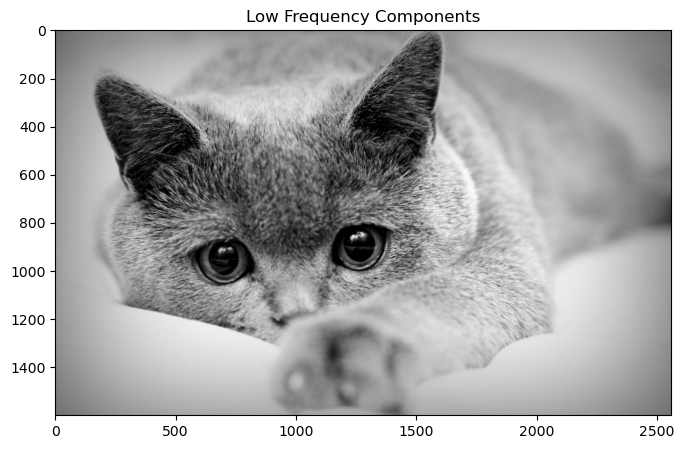

In [40]:
import matplotlib.pyplot as plt

# Step 13: Preview the images
plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
plt.imshow(image_low, cmap='gray')
plt.title('Low Frequency Components')


plt.show()


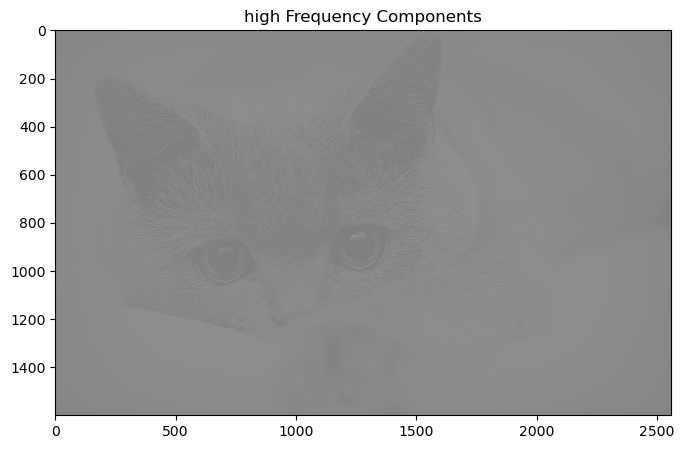

In [41]:
import matplotlib.pyplot as plt

# Step 13: Preview the images
plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
plt.imshow(image_high, cmap='gray')
plt.title('high Frequency Components')


plt.show()

In [42]:
# Use the image name in the paths of the resultant images
low_quantization_image_path = f'../data/processed/low_quantization_{image_name}.jpg'
high_quantization_image_path = f'../data/processed/high_quantization_{image_name}.jpg'

In [43]:
# Save the low-quality image
imageio.imsave(low_quantization_image_path, image_low)

# Save the high-quality image
imageio.imsave(high_quantization_image_path, image_high)

Lossy conversion from float64 to uint8. Range [-8.648724098003768e-14, 255.0000000000004]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [-2254.2142030539258, 2249.9872588149]. Convert image to uint8 prior to saving to suppress this warning.


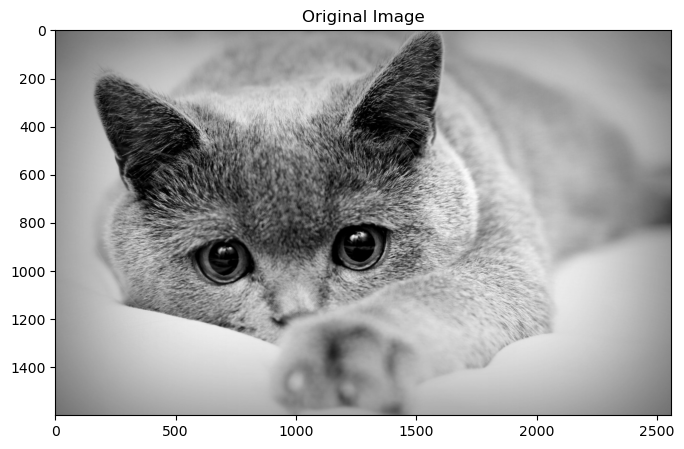

In [44]:
# Plot the original image
plt.figure(figsize=(10, 5))
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.show()

## Compare the original and reconstructed images

We are comparing the original and reconstructed images using Mean Squared Error (MSE), Peak Signal-to-Noise Ratio (PSNR), and compression ratio to evaluate the performance of our JPEG encoder and decoder.

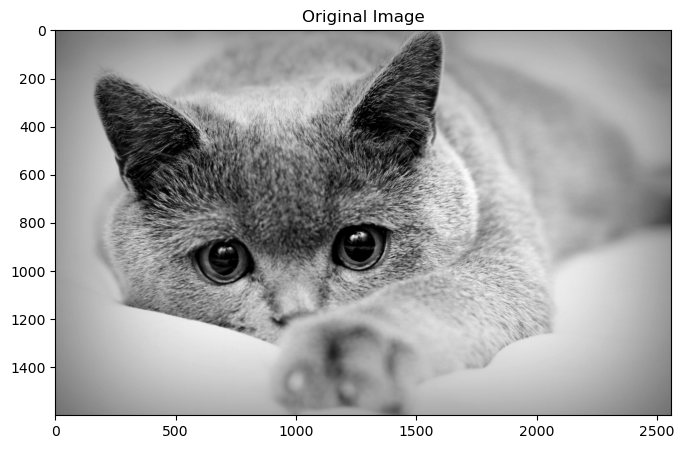

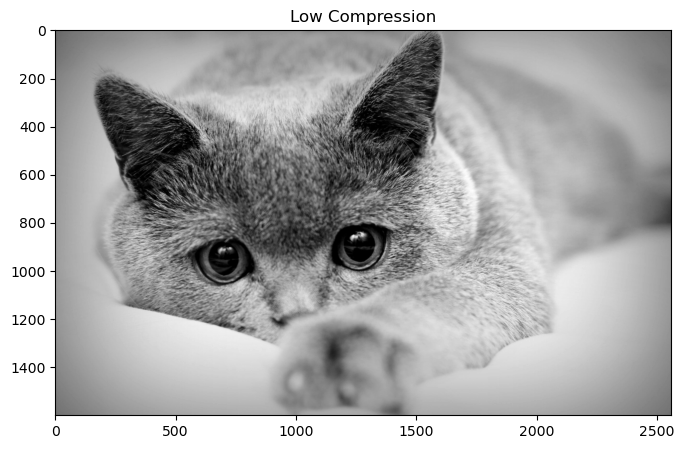

Mean Squared Error between the images: 1.0908586035486283e-26
Peak Signal-to-Noise Ratio: 307.7531189962717
Compression Ratio: 0.9628270879347134


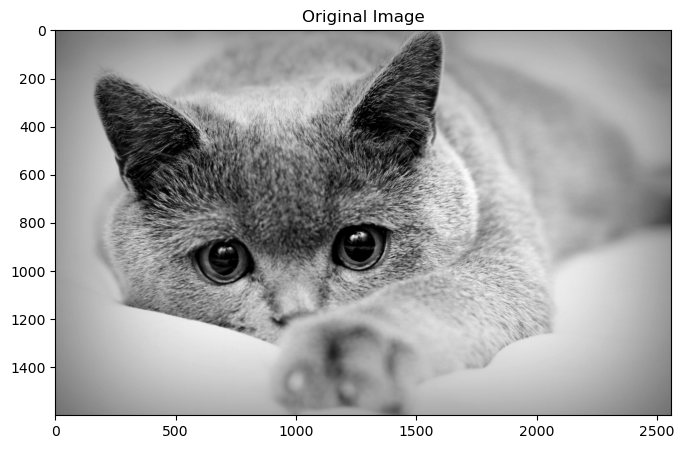

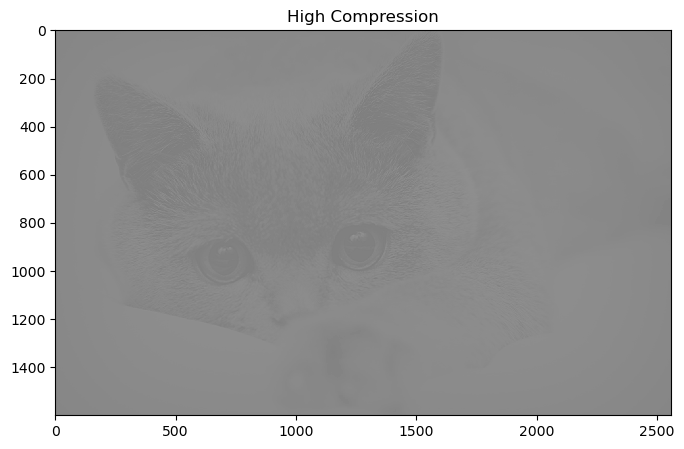

Mean Squared Error between the images: 6707.559789789424
Peak Signal-to-Noise Ratio: 9.865158082962198
Compression Ratio: 0.5911641983591971


In [67]:
# Step 14: Compare the original image with the low-compressed/high-compressed image
# Compare the images and store the results in a list
results = []
results.append(compare_images(original_image, image_low, load_image_path, low_quantization_image_path, 'Low Compression'))
results.append(compare_images(original_image, image_high, load_image_path, high_quantization_image_path, 'High Compression'))


In [68]:
import pandas as pd
# Convert the list to a DataFrame
df = pd.DataFrame(results, columns=['Title', 'MSE', 'PSNR', 'Compression Ratio'])

# Print the DataFrame
print(df)

              Title           MSE        PSNR  Compression Ratio
0   Low Compression  1.090859e-26  307.753119           0.962827
1  High Compression  6.707560e+03    9.865158           0.591164


## Choice of Quantization Table

In our JPEG encoder and decoder implementation, we provide two options for the quantization table: 'low' and 'high'. The choice of quantization table significantly impacts the balance between the level of compression and the quality of the reconstructed image.

1. **Low Quantization Table**: This table has lower values, meaning less information is lost during the quantization process. This results in higher quality for the reconstructed image, but less compression. This option is suitable when image quality is a priority over the size of the compressed file.

2. **High Quantization Table**: This table has higher values, meaning more information is lost during the quantization process. This results in lower quality for the reconstructed image, but more compression. This option is suitable when the size of the compressed file is a priority over image quality.

The choice between these two options depends on the specific requirements of the user. If maintaining image quality is paramount, the 'low' option would be the best choice. Conversely, if minimizing storage space is more important, the 'high' option would be more suitable.